In [1]:
import numpy as np
import random
import copy
import cv2 as cv
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
import time

## Generate a coastline

Mapping

0 - Terrain (solid ground, terrain)

1 - Sand (loose sand)

2 - Water

3 - Solid Objects ? 

In [247]:
def white_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*np.eye(x1.shape[0])
    else:
        return np.zeros(x1.shape[0], x2.shape[0])
    
def periodic_kernel(x1, x2, varSigma, period, lengthScale):
    if x2 is None:
        d = cdist(x1, x1)
    else:
        d = cdist(x1, x2)
    return varSigma*np.exp(-(2*np.sin((np.pi/period)*d)**2)/lengthScale**2)


def get_coast_noise(scaling_factor=3, period=1, noise_level=0.01):
    x = np.linspace(0,DIM_MAP, DIM_MAP).reshape(-1,1)
    K = periodic_kernel(x,x,1,period,1) + white_kernel(x,None,noise_level)
    mu = np.zeros(x.shape)
    
    f = scaling_factor* np.random.multivariate_normal(mu.flatten(), K, 1)[0]
    return f

In [248]:
GROUND_COLOR = [29,118,56]
SAND_COLOR = [153,229, 255]
WATER_COLOR = [204,134,41]
FRAC_GROUND, FRAC_SAND = 0.3, 0.3
DIM_MAP = 100


WAVE_FREQ = 20
WAVE_SPEED = 1
WAVE_DECAY = 0.6
WAVE_CUTOFF = 0.1
WAVE_RETREAT_COEFF = 0.8


SAND_PULL = 0.2
GROUND_PULL = 0.1
WATER_DECAY = 0.99


GROUND_COLOR.reverse()
SAND_COLOR.reverse()
WATER_COLOR.reverse()

In [249]:
def display_map(coast, waves_inp=[], waves_pos=[], stream=True, openCV=False):
    global GROUND_COLOR, SAND_COLOR, WATER_COLOR
    
    cv.namedWindow("Coast")
    
    img = np.zeros((coast.shape[0], coast.shape[1],3), dtype=int)
    coast_temp = copy.deepcopy(coast)
    coast_temp[:,:,0] = (coast_temp[:,:,0] / np.max(coast_temp[:,:,0])) * 255
    coast_temp[:,:,1] = (coast_temp[:,:,1] / np.max(coast_temp[:,:,1])) * 255
    coast_temp[:,:,2] = (coast_temp[:,:,2] / np.max(coast_temp[:,:,2])) * 255
    coast_temp = coast_temp[...,np.newaxis]
    img = np.array(GROUND_COLOR).reshape(1,1,-1)*coast_temp[:,:,0,:]   ## Ground Color
    img+= np.array(SAND_COLOR).reshape(1,1,-1)*coast_temp[:,:,1,:]   ## Sand Color
    img+= np.array(WATER_COLOR).reshape(1,1,-1)*coast_temp[:,:,2,:]   ## Water Color
    

    if len(waves_inp) > 0:
        for i in range(DIM_MAP):
            img[i,waves_inp[:,i]] = [0,0,255]

    if not openCV:
        plt.imshow(img)
        plt.show()



    if openCV:
        img = img.astype(np.uint8)
        img_cv = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        img_cv = cv.resize(img_cv, (1000,1000))
        
        cv.imshow("Coast", img_cv)
        if stream:
            cv.waitKey(2)
        else:
            cv.waitKey(0)
            cv.destroyWindow("Coast")
            cv.waitKey(1)

In [250]:
coast_map = np.zeros((DIM_MAP, DIM_MAP,3), dtype=np.int16)

In [251]:
coast_map[:,:int(DIM_MAP*FRAC_GROUND),0] = 100  ## Assign sand portion of the map
coast_map[:,int(DIM_MAP*FRAC_GROUND):int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)),1] = 100  ## Assign sand portion of the map
coast_map[:,int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)):, 2] = 100  ## Assign water portion of the map


-ve -> Push water towards sand


+ve -> Push sand towards water

In [252]:
rand_coast = get_coast_noise(scaling_factor=DIM_MAP / 20, period=0.5, noise_level=1 / DIM_MAP)
rand_terrain = get_coast_noise(scaling_factor=DIM_MAP/20, period=0.5, noise_level=1 / DIM_MAP)

In [253]:
def get_coast(coast_inp):
    temp_coast = copy.deepcopy(coast_inp)

    for i in range(len(rand_coast)):
        if rand_coast[i] < 0:
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND))+int(rand_coast[i]):,2] = 100
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND))+int(rand_coast[i]):,1] = 0
        else:
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)):int(rand_coast[i])+int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)), 1] = 100
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)):int(rand_coast[i])+int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)), 2] = 0
    
        if rand_terrain[i] < 0:
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]):int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)), 1] = 100
            temp_coast[i, int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]):int(DIM_MAP*(FRAC_GROUND+FRAC_SAND)), 0] = 0
        else:
            temp_coast[i, :int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]), 0] = 100
            temp_coast[i, :int(DIM_MAP*(FRAC_GROUND))+int(rand_terrain[i]), 1] = 0
    return temp_coast

In [254]:
def move_sand(coast_inp, waves, pos, wave_speeds):
    global WAVE_DECAY, SAND_PULL, GROUND_PULL, WAVE_CUTOFF, WAVE_RETREAT_COEFF

    
    waves = calculate_wave_pos(waves, pos)
    for wave_idx in range(len(waves)):
        for i in range(len(waves[0])):
            vert_idx = i 
            hor_idx = waves[0][i]
            curr_pix = coast_inp[vert_idx, hor_idx]
            if wave_speeds[wave_idx][i] > WAVE_CUTOFF:
                left_pix = coast_inp[vert_idx,hor_idx-1]
                if left_pix[0] == 0 and left_pix[1] == 0:
                    continue
                
                wave_speeds[wave_idx][i] *= WAVE_DECAY
                if wave_speeds[wave_idx][i] < 0.1:
                    wave_speeds[wave_idx][i] = -1
                    continue
                new_curr_pix = copy.deepcopy(curr_pix)
                new_curr_pix[0] = curr_pix[0] - curr_pix[0]* GROUND_PULL*wave_speeds[wave_idx][i]
                new_curr_pix[1] = curr_pix[1] - curr_pix[1]* SAND_PULL*wave_speeds[wave_idx][i]
                new_curr_pix[2] = curr_pix[2] - curr_pix[2] * WATER_DECAY
                coast_inp[vert_idx, hor_idx] = new_curr_pix
                
                
                left_pix[0] = left_pix[0] + curr_pix[0]* GROUND_PULL*wave_speeds[wave_idx][i]
                left_pix[1] = left_pix[1] + curr_pix[1]* SAND_PULL*wave_speeds[wave_idx][i]
                left_pix[2] = left_pix[2] + curr_pix[2] * WATER_DECAY
                coast_inp[vert_idx, hor_idx-1] = left_pix

            
            elif wave_speeds[wave_idx][i] < 0:
                if curr_pix[0] == 0 and curr_pix[1] == 0 and curr_pix[2] > 1:
                    wave_speeds[wave_idx][i] == 0
                    continue
                right_pix = coast_inp[vert_idx, hor_idx+1]
                # print(right_pix)
                # print(curr_pix)
                # if right_pix[0] == 0 and right_pix[1] == 0 and right_pix[2] == 1:
                #     ## There is no sand or ground to the right/ Ocean / End the wave
                #     wave_speeds[wave_idx][i] == 0
                #     continue
                # print("RETREAT WAVE")
                new_curr_pix = copy.deepcopy(curr_pix)
                new_curr_pix[0] = curr_pix[0] - WAVE_RETREAT_COEFF * curr_pix[0]*GROUND_PULL*wave_speeds[wave_idx][i]
                new_curr_pix[1] = curr_pix[1] - WAVE_RETREAT_COEFF * curr_pix[1]*SAND_PULL*wave_speeds[wave_idx][i]
                new_curr_pix[2] = curr_pix[2] - WAVE_RETREAT_COEFF * curr_pix[2] * WATER_DECAY
                
                right_pix[0] = right_pix[0] + WAVE_RETREAT_COEFF * curr_pix[0]*GROUND_PULL*wave_speeds[wave_idx][i]
                right_pix[1] = right_pix[1] + WAVE_RETREAT_COEFF * curr_pix[1]*SAND_PULL*wave_speeds[wave_idx][i]
                right_pix[2] = right_pix[2] + WAVE_RETREAT_COEFF * curr_pix[2] * WATER_DECAY

                coast_inp[vert_idx, hor_idx] = new_curr_pix
                coast_inp[vert_idx, hor_idx+1] = right_pix
                
                wave_speeds[wave_idx][i] *= WAVE_DECAY
        # print("MOVED_WAVE")
    return coast_inp

In [255]:
def calculate_wave_pos(waves, pos):
    return np.clip(np.add(waves,pos),0,DIM_MAP-1).astype(np.int16)

def run_sim(num_timesteps, plots=False):
    global WAVE_FREQ, WAVE_SPEED, coast_map

    temp_coast_map = get_coast(coast_map)
    waves = np.array([get_coast_noise(scaling_factor=10, period=0.5, noise_level=1/DIM_MAP).astype(np.int16)])
    pos = np.array([np.ones(waves[0].shape) * DIM_MAP])
    wave_speeds = np.array([np.ones(waves[0].shape) * WAVE_SPEED])

    
    for t in range(1,num_timesteps):
        if t%WAVE_FREQ == 0:
            new_wave = get_coast_noise(scaling_factor=10, period=0.5, noise_level=1/DIM_MAP).astype(np.int16).reshape(1,-1)
            waves = np.append(waves, new_wave, axis=0)
            pos = np.append(pos,np.ones(new_wave.shape) * DIM_MAP, axis=0)
            wave_speeds = np.append(wave_speeds, np.array([np.ones(waves[0].shape) * WAVE_SPEED]), axis=0)

            if plots:
                display_map(temp_coast_map, calculate_wave_pos(waves, pos))
        temp_coast_map = move_sand(temp_coast_map, waves, pos, wave_speeds)
        pos = pos - wave_speeds
        if plots:
            display_map(temp_coast_map, calculate_wave_pos(waves, pos), openCV=False)
        
        # time.sleep(0.5)
    return temp_coast_map

In [256]:
ret = run_sim(1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-36..197].


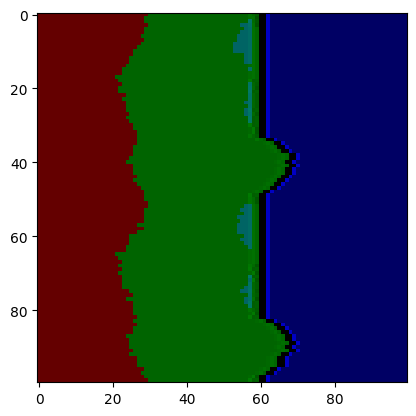

In [257]:
plt.imshow(ret)

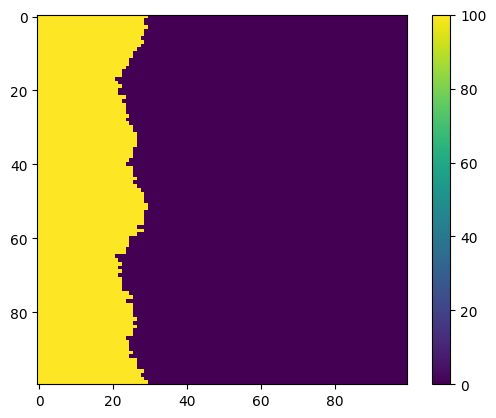

In [258]:
plt.imshow(ret[:,:,0])
plt.colorbar()

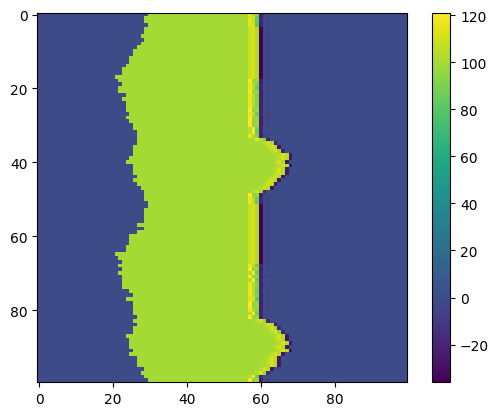

In [259]:
plt.imshow(ret[:,:,1])
plt.colorbar()

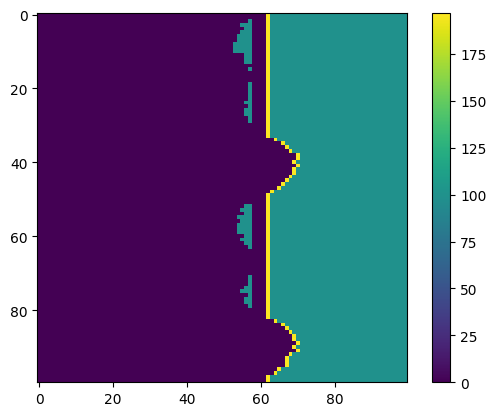

In [260]:
plt.imshow(ret[:,:,2])
plt.colorbar()